# 1. Upload raw matrix counts that need batch correction (at least two different original datasets )

In [4]:
import pandas as pd
import anndata as ad
import scanpy as sc
import glob
import numpy as np
import QCPipe

In [5]:
def reorder_AnnData(AnnData, descending = True):
    AnnData.obs['total_counts'] = AnnData.X.sum(axis=1)
    if(descending==True):
        AnnData = AnnData[np.argsort(AnnData.obs['total_counts'])[::-1]].copy()
        AnnData.uns['Order'] = 'Descending'
    elif(descending==False):
        AnnData = AnnData[np.argsort(AnnData.obs['total_counts'])[:]].copy()
        AnnData.uns['Order'] = 'Ascending'
    return(AnnData)

def read_dropest(dir_path,reorder=True):
    data_matrix = glob.glob(dir_path+"/*.mtx")[0]
    data_genes = glob.glob(dir_path+"/*features.*")[0]
    data_barcodes = glob.glob(dir_path+"/*barcodes.*")[0]
    adata = sc.read_mtx(data_matrix).T
    adata.var.index = pd.read_csv(data_genes,header=None)[0].values
    adata.obs.index = pd.read_csv(data_barcodes,header=None)[0].values
    adata.obs.index.name = 'Cells'
    adata.var.index.name = 'Genes'
    adata = reorder_AnnData(adata,descending=True)
    adata.raw = adata
    return(adata)

In [7]:
# dataset #1
adata1 = read_dropest('cmraw_sparse1')
adata1

AnnData object with n_obs × n_vars = 39755 × 25733
    obs: 'total_counts'
    uns: 'Order'

In [10]:
adata1.X.sum(axis=1)

matrix([[3.4853e+04],
        [2.9552e+04],
        [2.7744e+04],
        ...,
        [2.0000e+01],
        [2.0000e+01],
        [2.0000e+01]], dtype=float32)

In [11]:
adata1.raw = adata1

In [12]:
adata1.var_names

Index(['RP5-857K21.4', 'SSU72', 'CCNL2', 'AURKAIP1', 'FAAP20', 'RPL22', 'NOL9',
       'KLHL21', 'PARK7', 'ENO1',
       ...
       'P2RX2', 'ACCSL', 'RP11-266J6.2', 'RP11-298J23.5', 'RP11-507K12.1',
       'RP11-756H6.1', 'AC113608.1', 'SOX14', 'CAPN3', 'RP11-261N11.8'],
      dtype='object', name='Genes', length=25733)

In [13]:
# dataset #2
adata2 = read_dropest('cmraw_sparse2')
adata2

AnnData object with n_obs × n_vars = 37349 × 24724
    obs: 'total_counts'
    uns: 'Order'

In [14]:
adata2.X.sum(axis=1)

matrix([[3.0678e+04],
        [3.0139e+04],
        [2.6930e+04],
        ...,
        [2.0000e+01],
        [2.0000e+01],
        [2.0000e+01]], dtype=float32)

In [15]:
adata2.raw = adata2

# 2. Preliminary analysis in scanpy

In [16]:
adata1.var_names_make_unique()

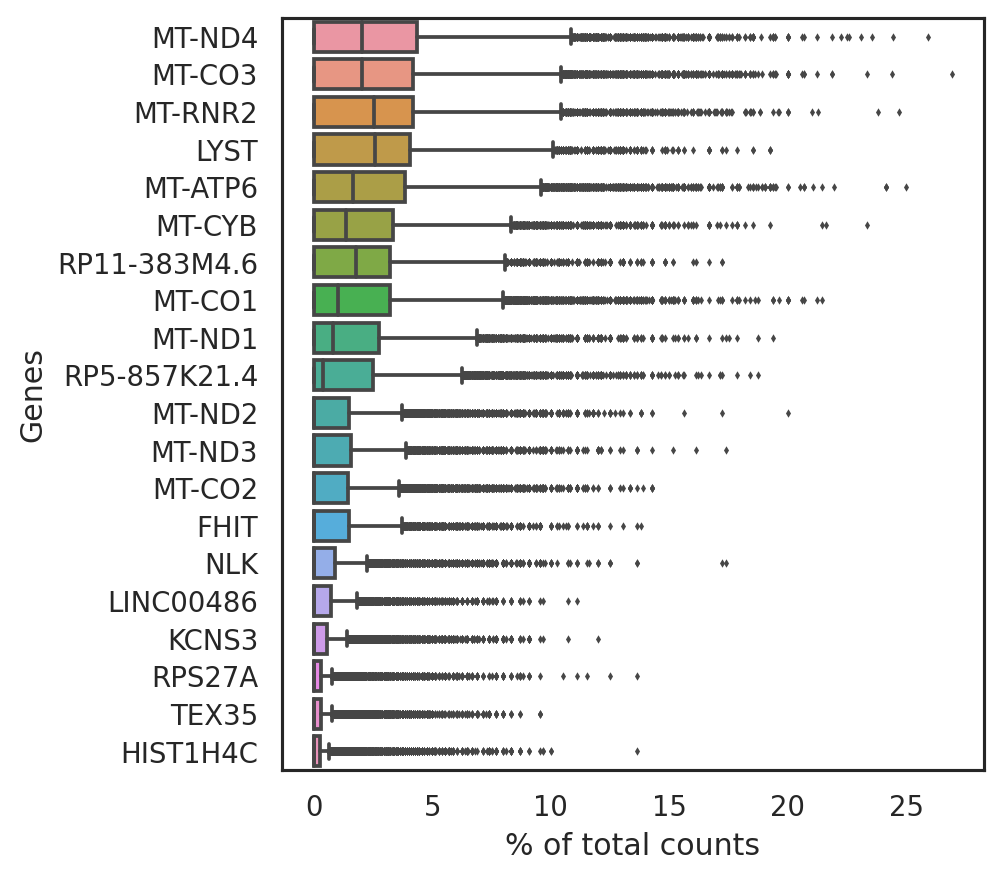

In [17]:
sc.pl.highest_expr_genes(adata1, n_top=20)

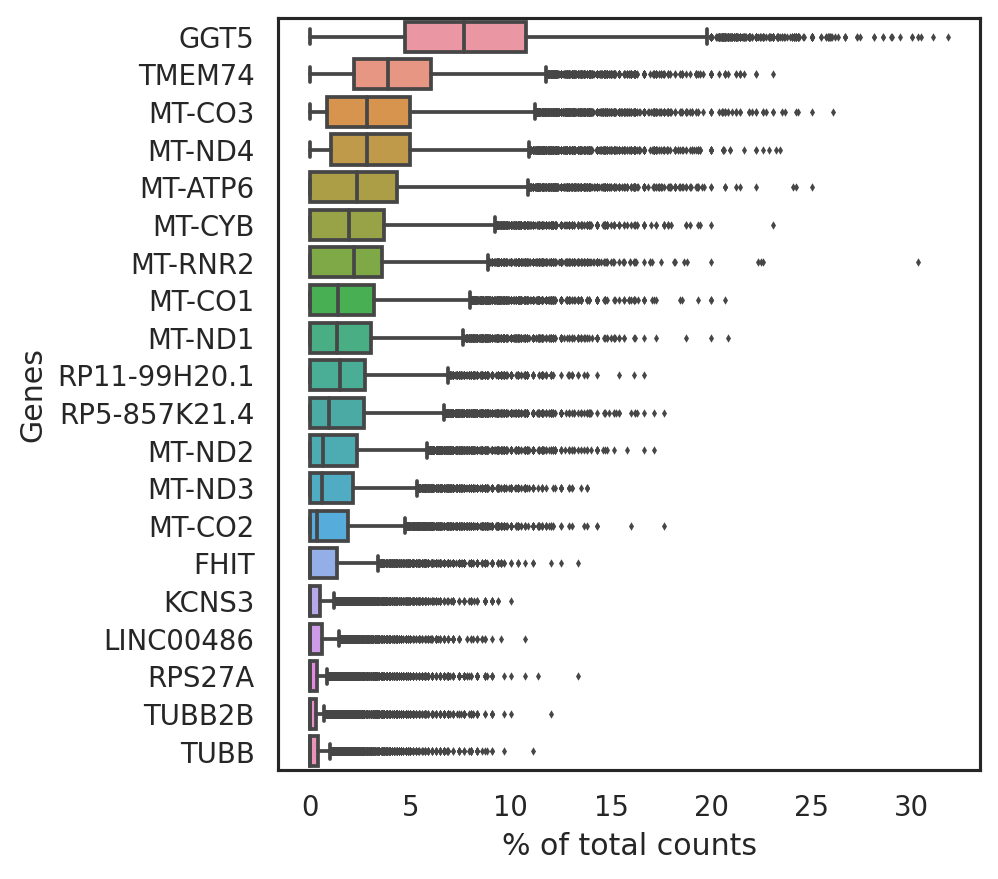

In [18]:
adata2.var_names_make_unique()
sc.pl.highest_expr_genes(adata2, n_top=20)

In [19]:
# this next block is all analysis for dataset #1

In [20]:
adata1.var['mt'] = adata1.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

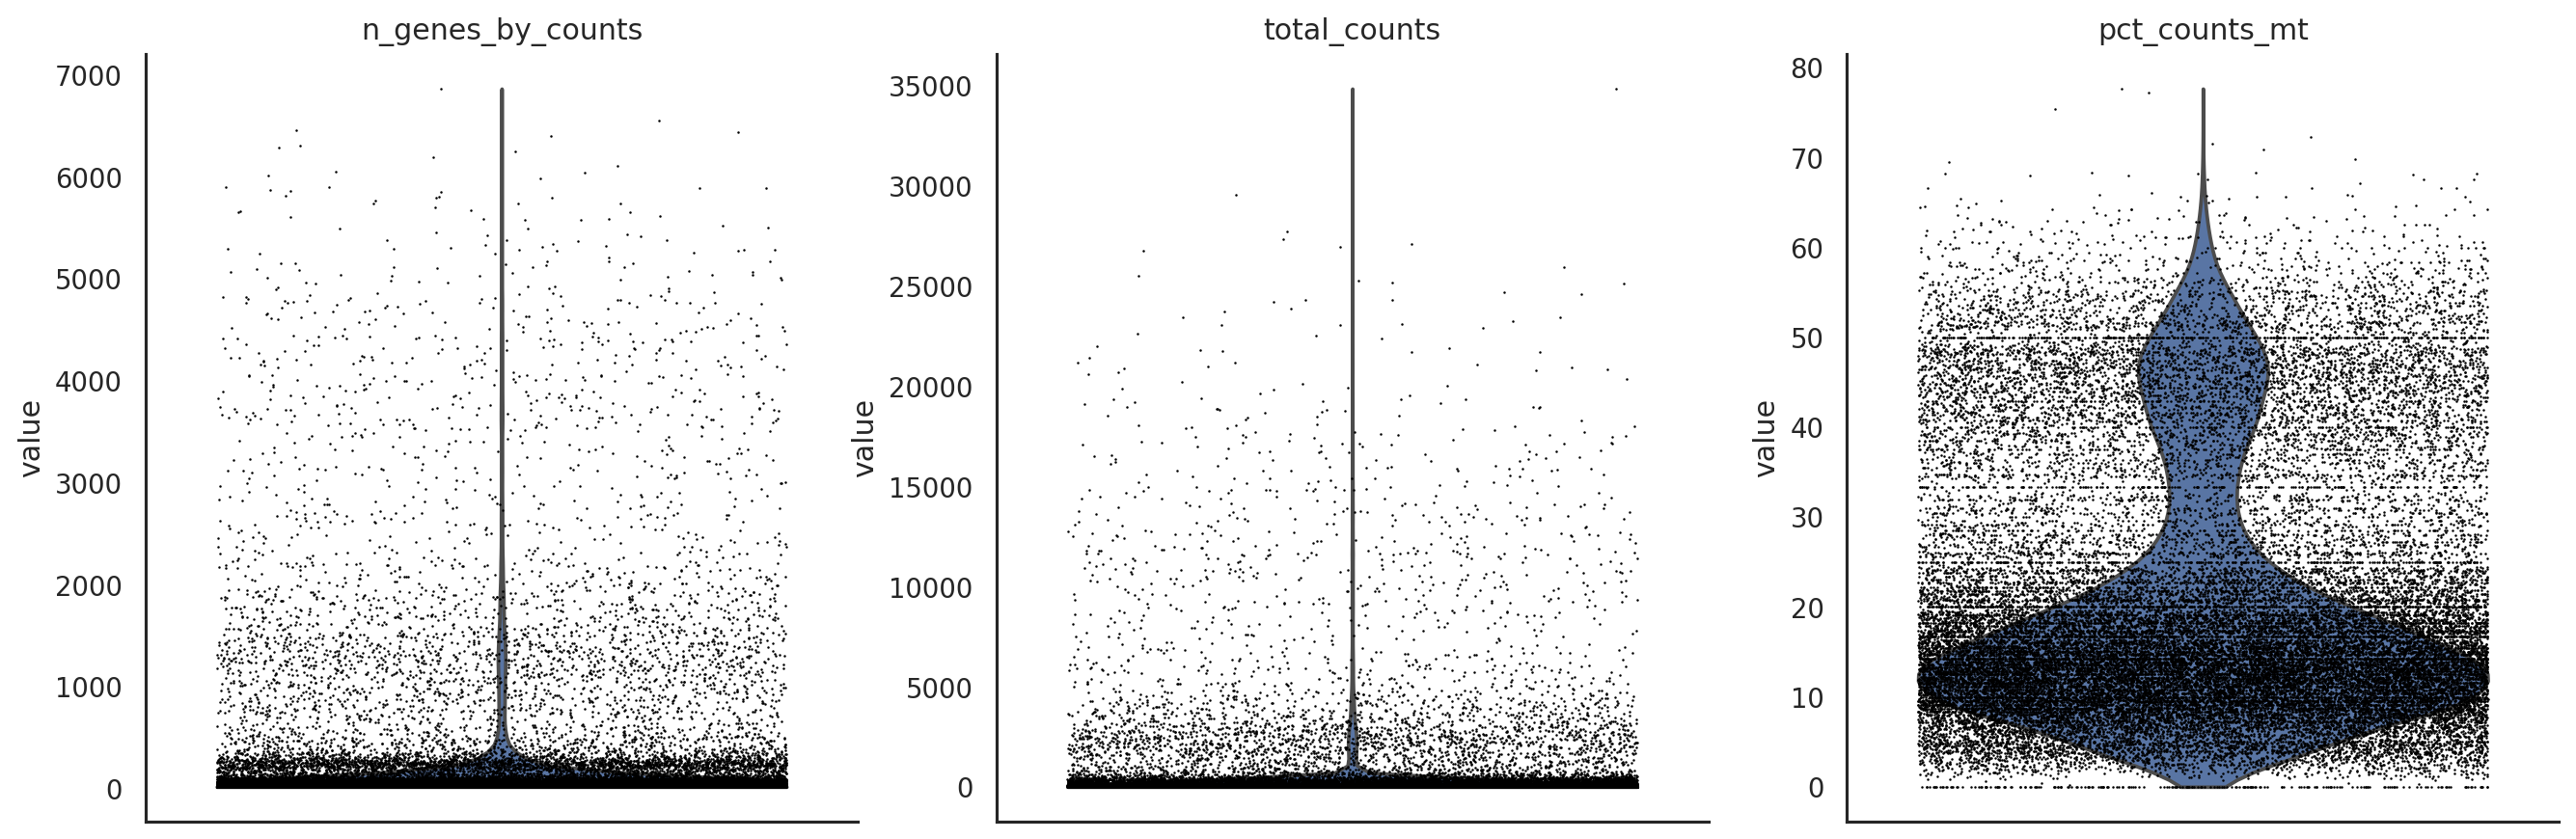

In [21]:
sc.pl.violin(adata1, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

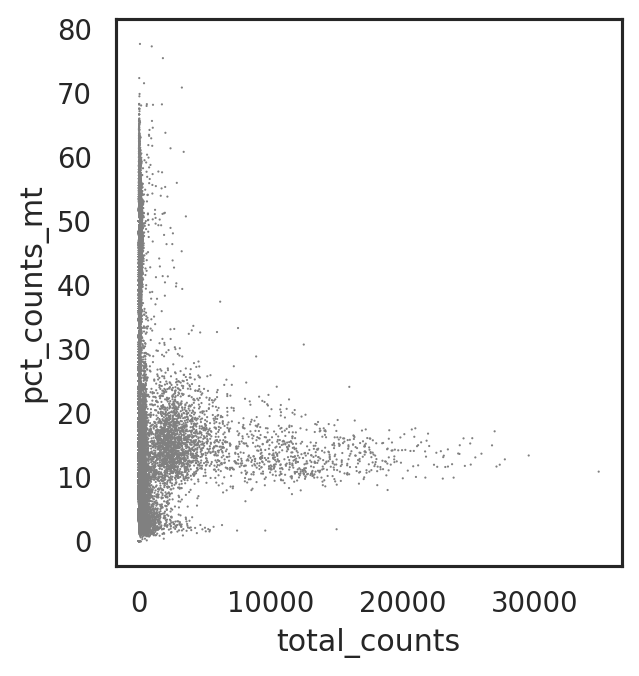

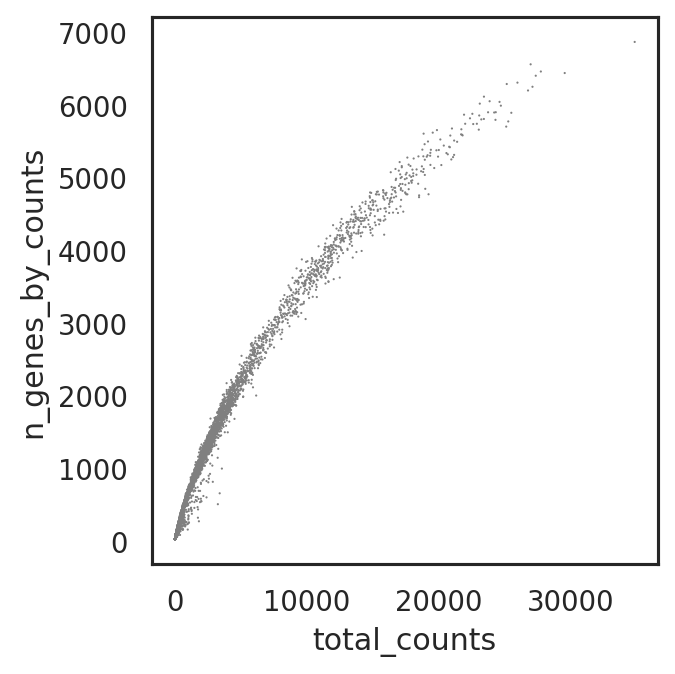

In [22]:
sc.pl.scatter(adata1, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata1, x='total_counts', y='n_genes_by_counts')

In [23]:
adata1 = adata1[adata1.obs.n_genes_by_counts < 5000, :]
adata1 = adata1[adata1.obs.pct_counts_mt < 25, :]

Calculating QC Metrics


/home/jonathan/chuck_project/qc_utils.py:36: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_in.var['Mitochondrial'] = adata_in.var.index.str.startswith(mito_tag)
OMP: Info #274: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Inflection point at [ 3526  7378 11230] for [0, 15, 30] percentiles of greatest secant distances


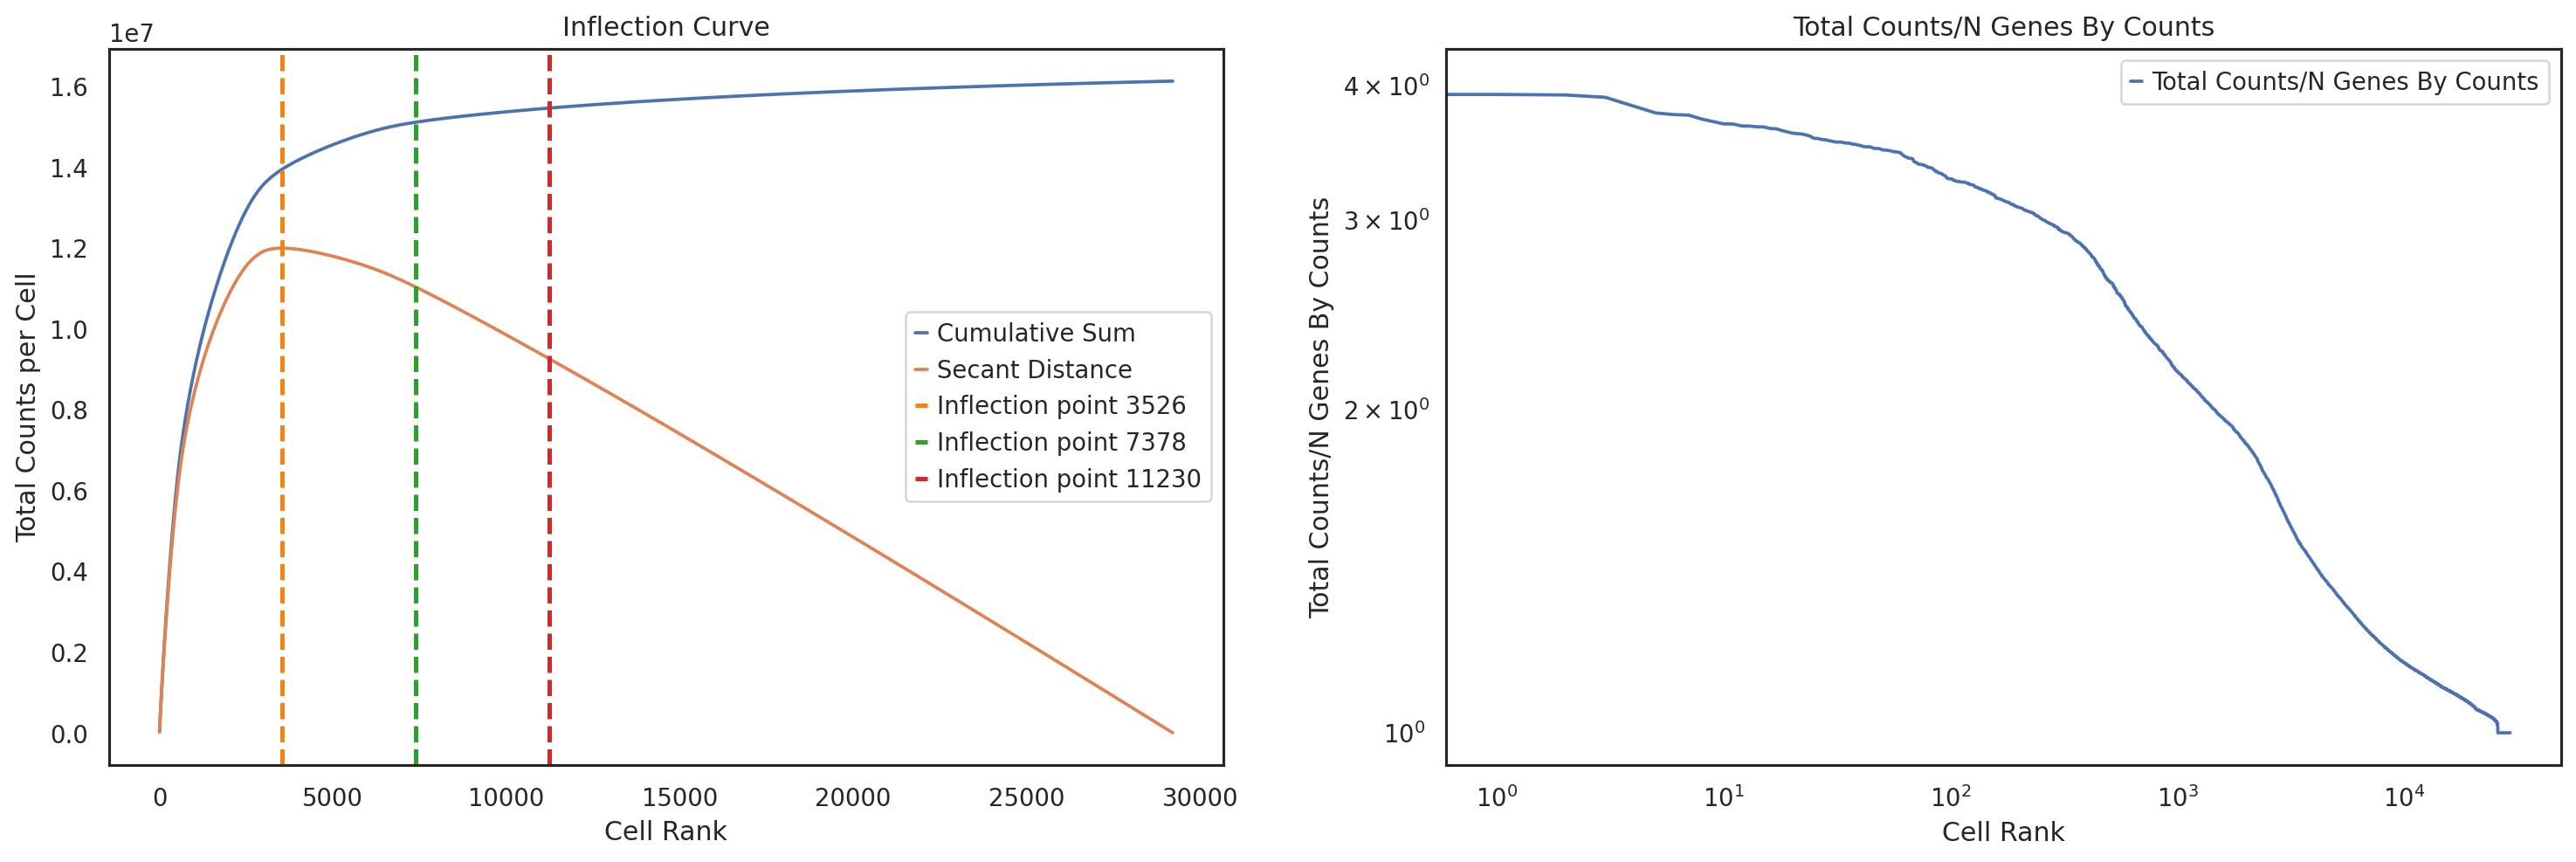

In [24]:
inf1 = QCPipe.qc.find_inflection(adata1)

In [25]:
inf1[0]

3526

In [26]:
sc.pp.filter_cells(adata1,min_counts=adata1[inf1[0]].obs.total_counts[0]) ; adata1

AnnData object with n_obs × n_vars = 3530 × 25733
    obs: 'total_counts', 'n_genes_by_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_Mitochondrial', 'log1p_total_counts_Mitochondrial', 'pct_counts_Mitochondrial', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'Mitochondrial', 'log1p_mean_counts', 'log1p_total_counts'
    uns: 'Order'

In [27]:
sc.pp.normalize_total(adata1) #Normalize data by the median counts per single cell library
adata1.X = np.arcsinh(adata1.X).copy() #Transform the data by using an inverse hyperbolic sine transform, this eliminates the need for adding a pseudocount 
sc.pp.scale(adata1) #Scale and center the data for interpretability

In [28]:
sc.pp.pca(adata1,random_state=0)

In [29]:
import tqdm as notebook_tqdm

In [30]:
neighborhood_k = np.sqrt(adata1.n_obs).astype(int) #We have found that scaling the K to equal the square root of the total number of neighbors to be effective
sc.pp.neighbors(adata1,n_neighbors=neighborhood_k,use_rep='X_pca',random_state=0) #Calculate this KNN based off of the PCA distances

/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
sc.tl.umap(adata1,min_dist=0.25,random_state=0)

In [32]:
sc.tl.leiden(adata1,resolution=2,random_state=0) #Here we use a resolution of 2, which should yield 30+ clusters. This step may take a while.

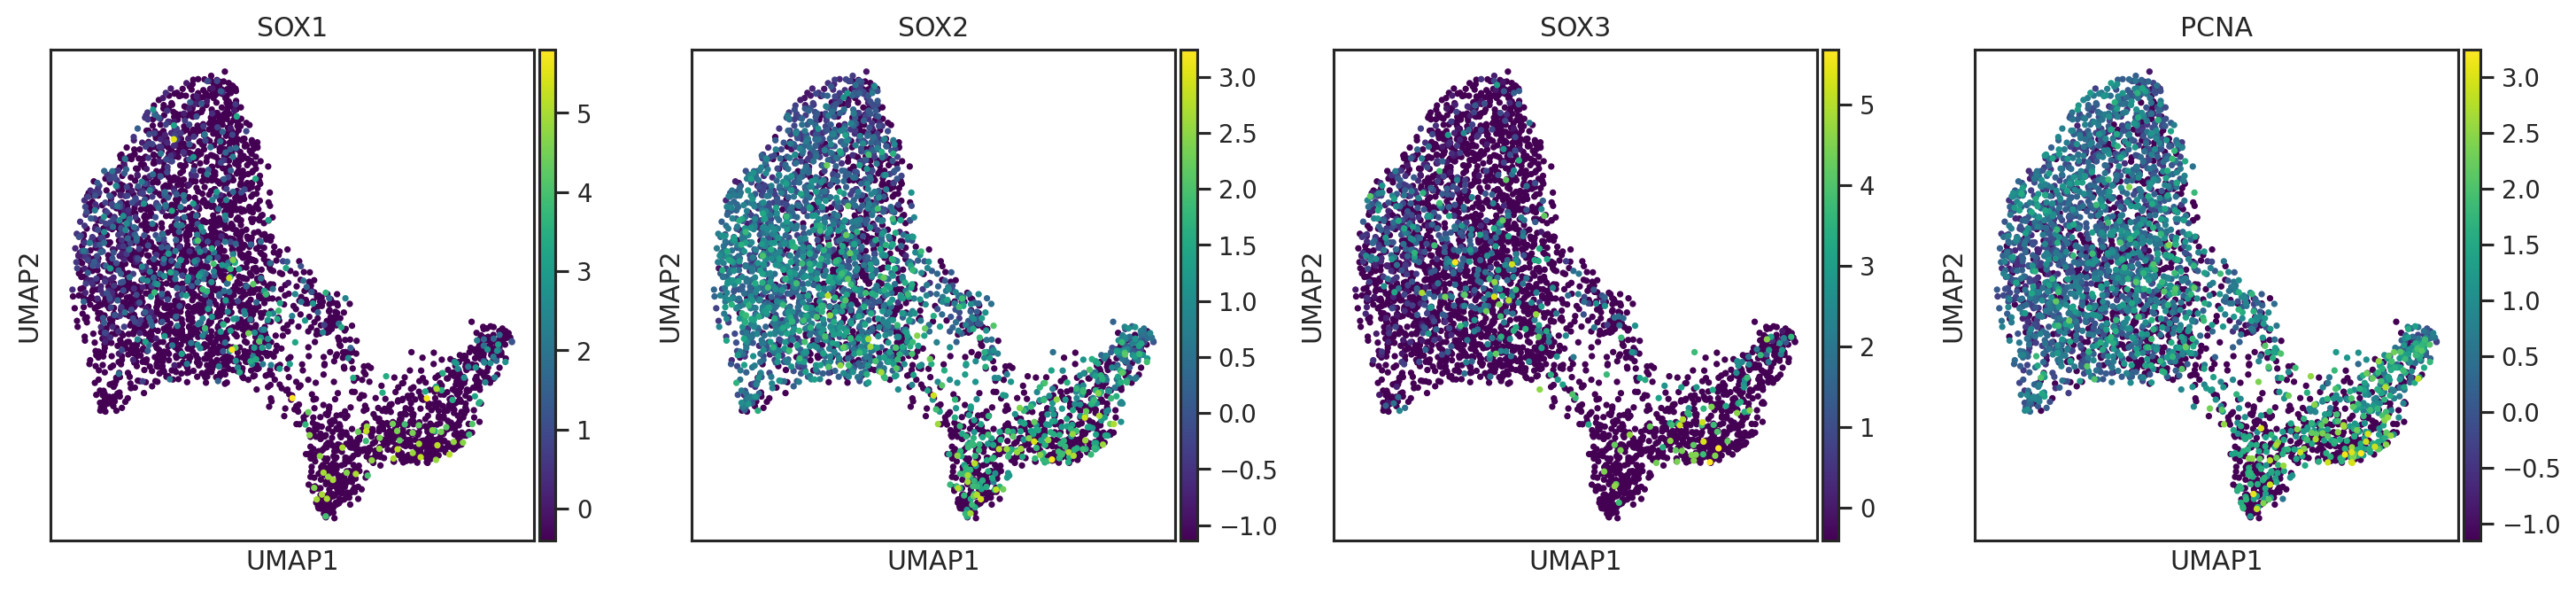

In [33]:
sc.pl.umap(adata1,color=['SOX1','SOX2','SOX3','PCNA'],use_raw=False,cmap='viridis')

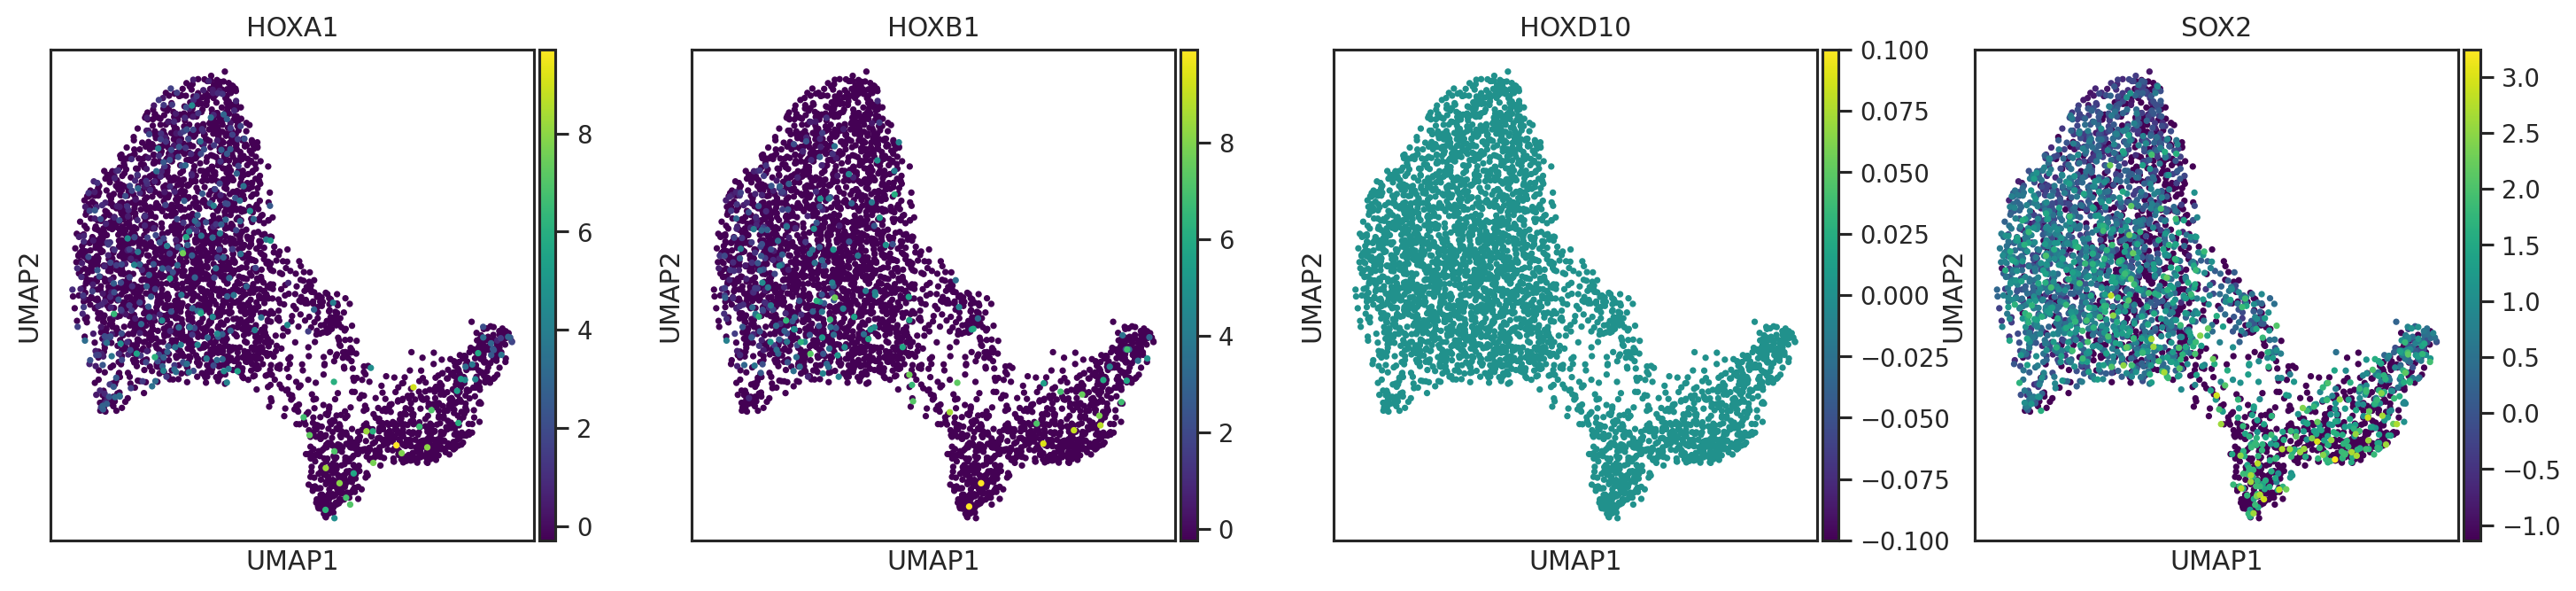

In [34]:
sc.pl.umap(adata1,color=['HOXA1','HOXB1','HOXD10','SOX2'],use_raw=False,cmap='viridis')

In [35]:
# this next block is all analysis for dataset #2

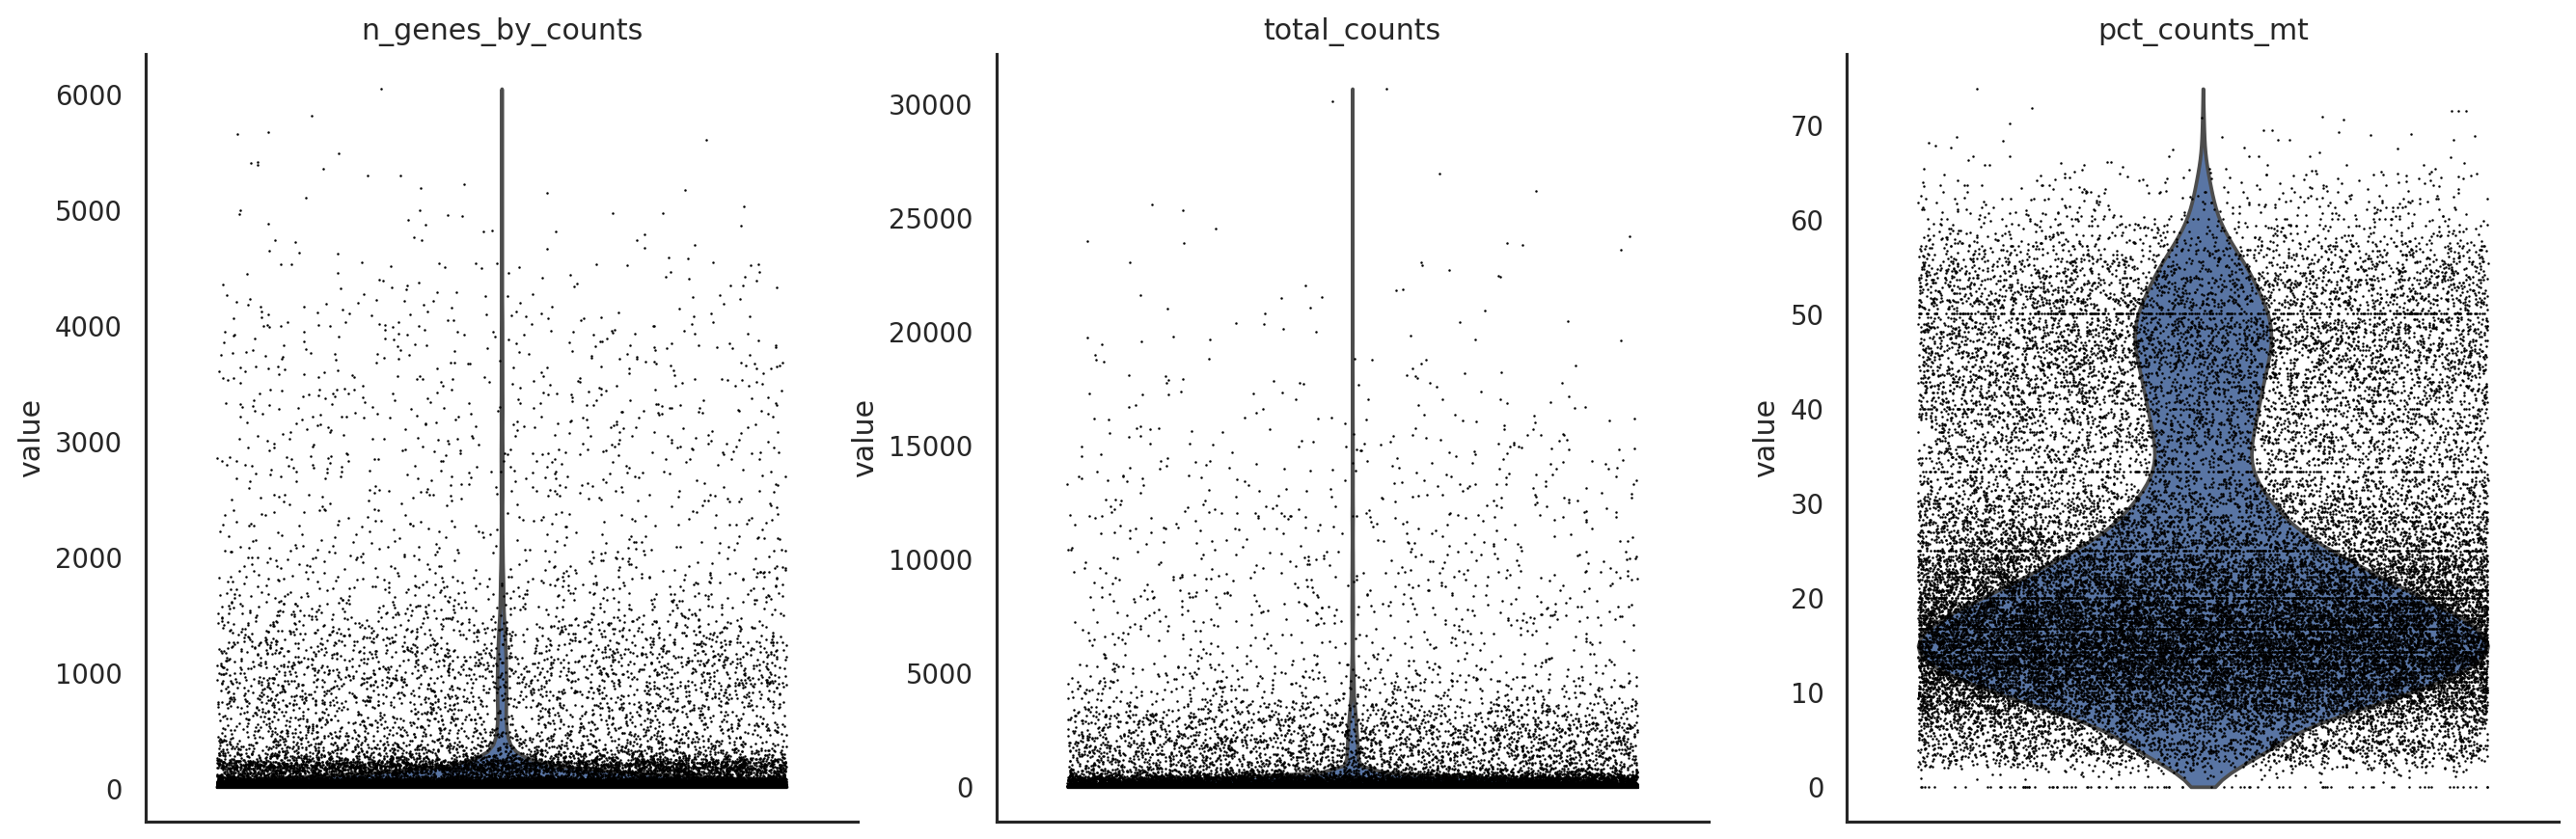

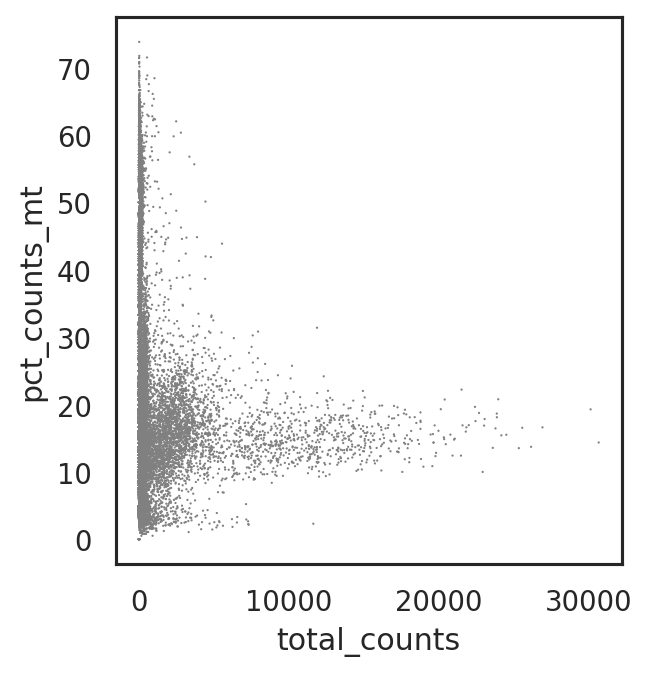

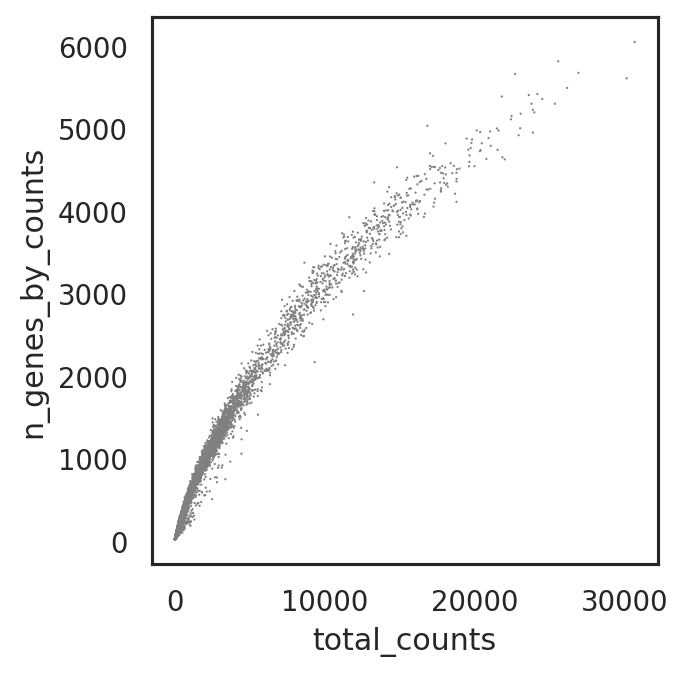

In [36]:
adata2.var['mt'] = adata2.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata2, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata2, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

sc.pl.scatter(adata2, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata2, x='total_counts', y='n_genes_by_counts')

In [37]:
adata2 = adata2[adata2.obs.n_genes_by_counts < 5000, :]
adata2 = adata2[adata2.obs.pct_counts_mt < 25, :]

Calculating QC Metrics


/home/jonathan/chuck_project/qc_utils.py:36: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_in.var['Mitochondrial'] = adata_in.var.index.str.startswith(mito_tag)


Inflection point at [ 3596  6822 10049] for [0, 15, 30] percentiles of greatest secant distances


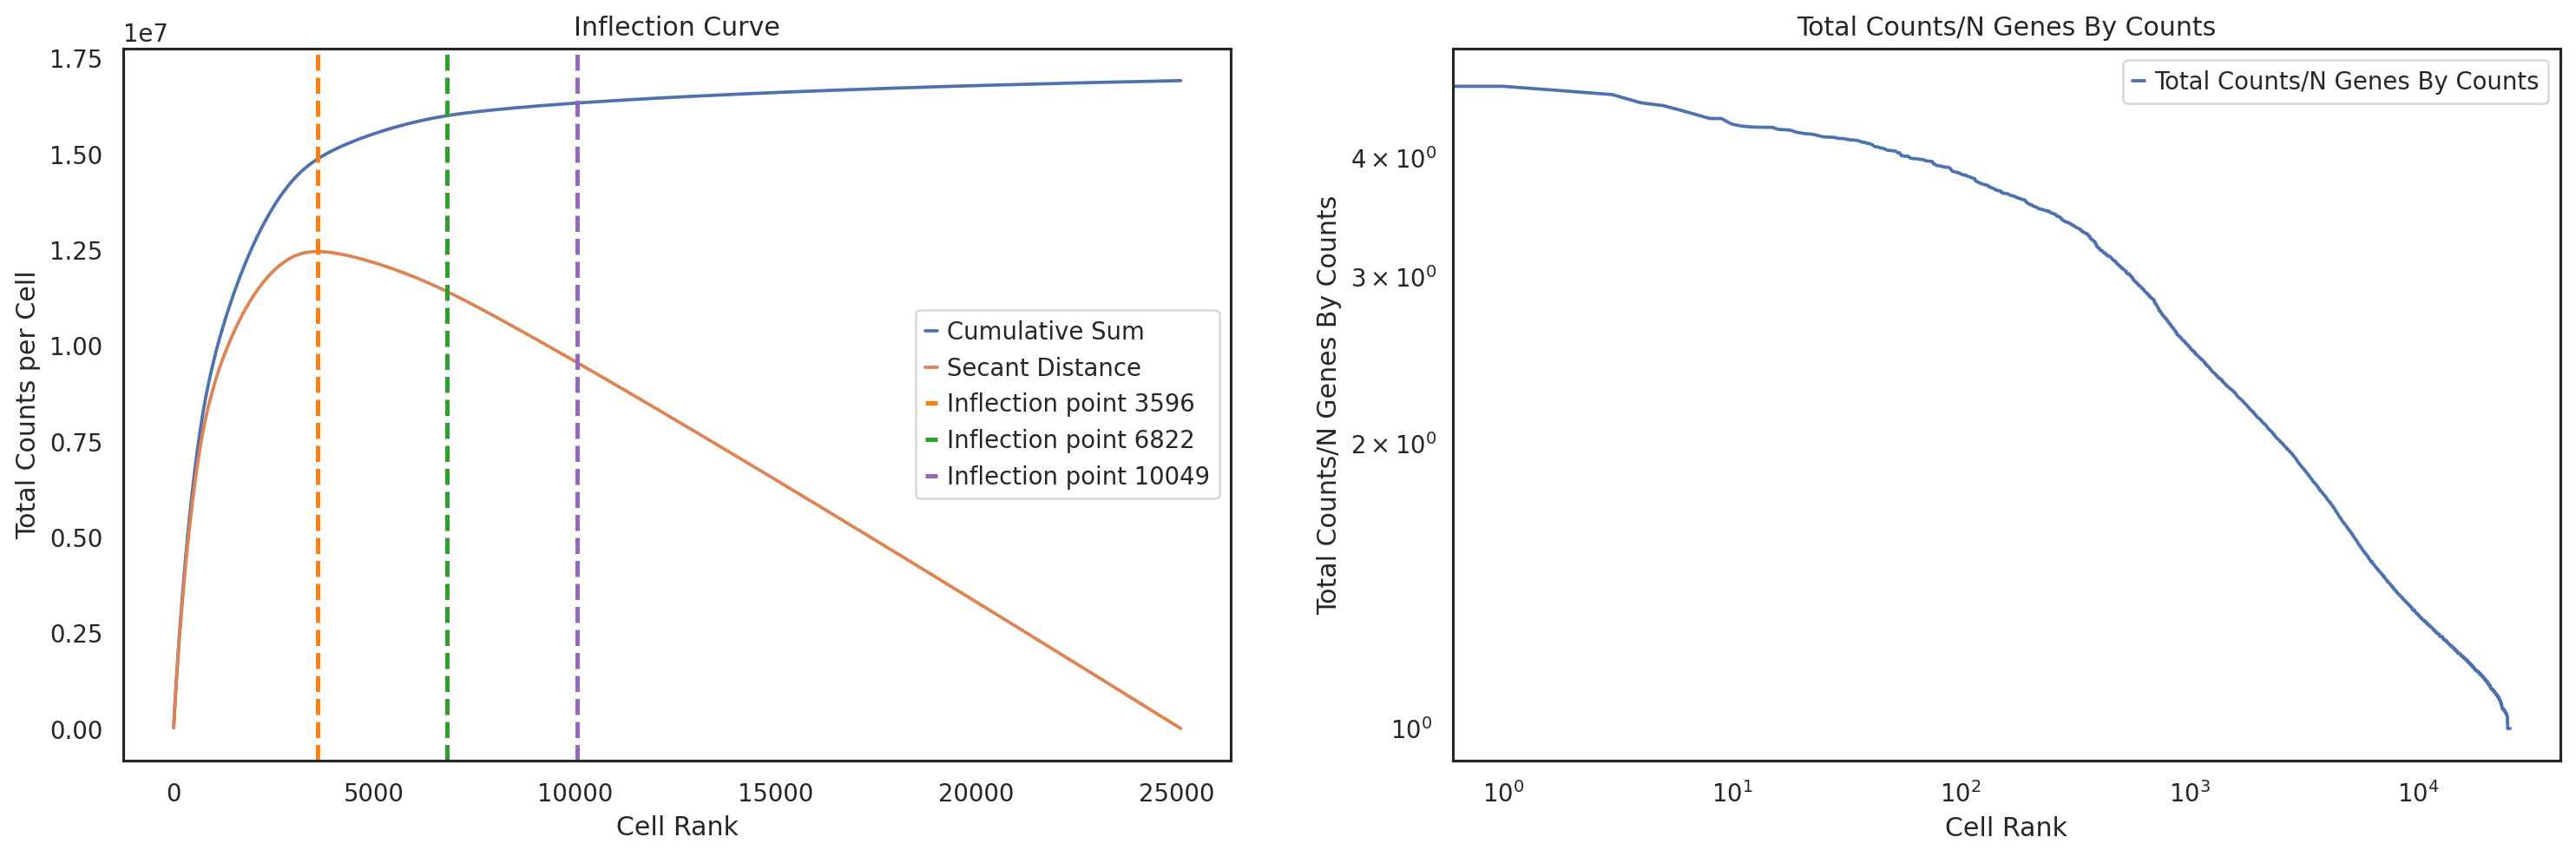

In [38]:
inf2 = QCPipe.qc.find_inflection(adata2)

In [39]:
sc.pp.filter_cells(adata2,min_counts=adata2[inf2[0]].obs.total_counts[0]) ; adata2

AnnData object with n_obs × n_vars = 3598 × 24724
    obs: 'total_counts', 'n_genes_by_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_Mitochondrial', 'log1p_total_counts_Mitochondrial', 'pct_counts_Mitochondrial', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'Mitochondrial', 'log1p_mean_counts', 'log1p_total_counts'
    uns: 'Order'

In [40]:
sc.pp.normalize_total(adata2) #Normalize data by the median counts per single cell library
adata2.X = np.arcsinh(adata2.X).copy() #Transform the data by using an inverse hyperbolic sine transform, this eliminates the need for adding a pseudocount 
sc.pp.scale(adata2) #Scale and center the data for interpretability

sc.pp.pca(adata2,random_state=0)

neighborhood_k = np.sqrt(adata2.n_obs).astype(int) #We have found that scaling the K to equal the square root of the total number of neighbors to be effective
sc.pp.neighbors(adata2,n_neighbors=neighborhood_k,use_rep='X_pca',random_state=0) #Calculate this KNN based off of the PCA distances

sc.tl.umap(adata2,min_dist=0.25,random_state=0)
sc.tl.leiden(adata2,resolution=2,random_state=0) #Here we use a resolution of 2, which should yield 30+ clusters. This step may take a while.

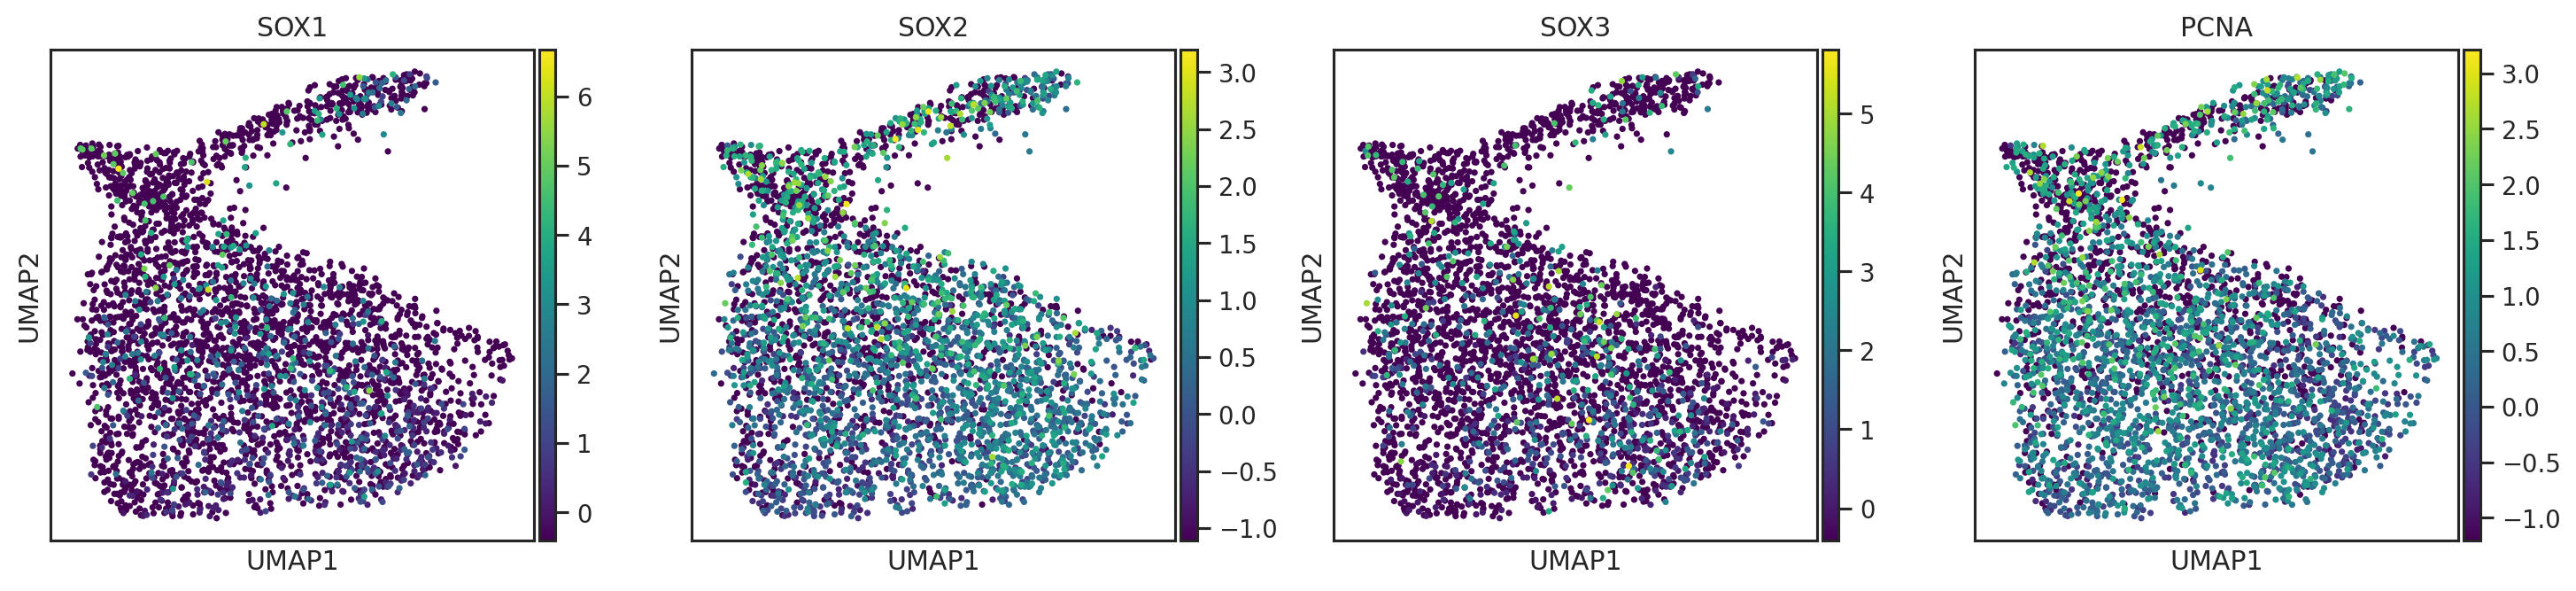

In [41]:
sc.pl.umap(adata2,color=['SOX1','SOX2','SOX3','PCNA'],use_raw=False,cmap='viridis')

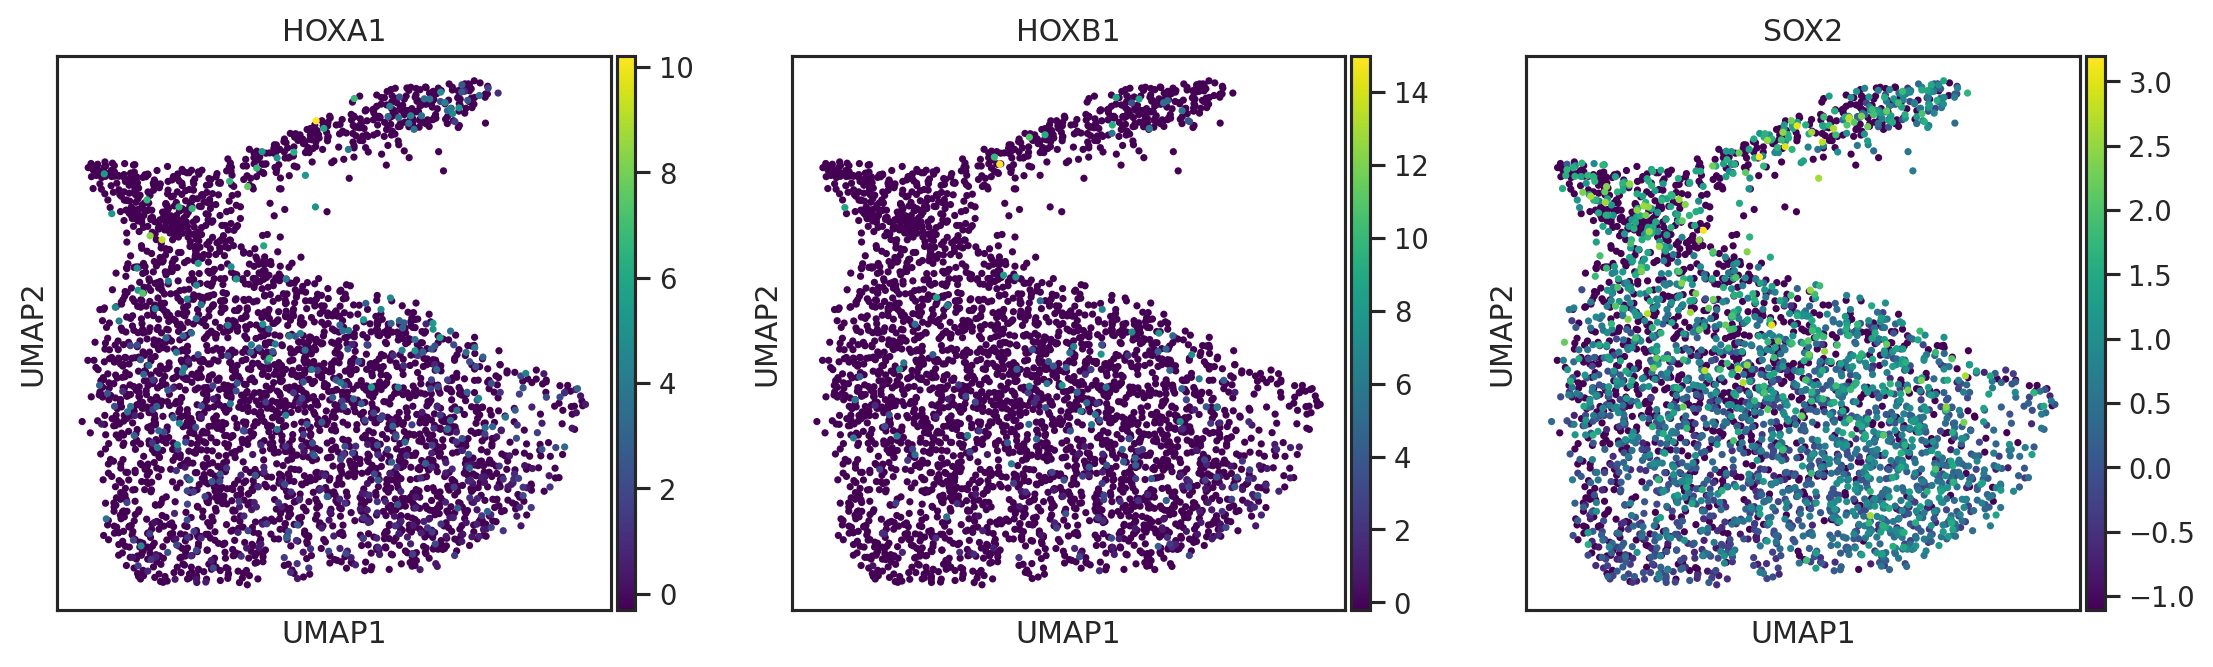

In [42]:
sc.pl.umap(adata2,color=['HOXA1','HOXB1','SOX2'],use_raw=False,cmap='viridis')

In [43]:
adata1.X.sum(axis=1)

array([  667.797  ,   836.88086,  1268.0199 , ..., -1925.4589 ,
       -1701.9001 , -1845.1007 ], dtype=float32)

In [44]:
adata2.X.sum(axis=1)

array([  712.9363 ,  1046.638  ,   681.58057, ..., -1626.1366 ,
       -1405.6138 , -1536.4271 ], dtype=float32)

In [45]:
adata1.X = adata1.raw.X
adata2.X = adata2.raw.X

In [46]:
adata1.X.sum(axis=1)

matrix([[19237.],
        [18989.],
        [18523.],
        ...,
        [  552.],
        [  552.],
        [  552.]], dtype=float32)

# 2.2 Combine ANDATA objects

In [47]:
import random
np.random.seed(56)
random.seed(56)

In [48]:
sc.set_figure_params(dpi=80) #Set figure size to 200 dpi for legibility
sc.settings.verbosity = 3 #Set scanpy verbosity to 3 for in depth function run information

In [49]:
batch_name = ['1','2']

In [50]:
adata = adata1.concatenate(adata2,join='outer',fill_value=0,batch_categories=batch_name)

/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [42]:
adata.write_h5ad('sparse_concat.h5ad',compression='gzip')

TypeError: Can't implicitly convert non-string objects to strings

Above error raised while writing key 'mt-1' of <class 'h5py._hl.group.Group'> to /

In [51]:
adata.obs['batch'].value_counts()

2    3598
1    3530
Name: batch, dtype: int64

In [52]:
adata

AnnData object with n_obs × n_vars = 7128 × 27153
    obs: 'total_counts', 'n_genes_by_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_Mitochondrial', 'log1p_total_counts_Mitochondrial', 'pct_counts_Mitochondrial', 'n_counts', 'leiden', 'batch'
    var: 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'Mitochondrial-1', 'log1p_mean_counts-1', 'log1p_total_counts-1', 'mean-1', 'std-1', 'mt-2', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'Mitochondrial-2', 'log1p_mean_counts-2', 'log1p_total_counts-2', 'mean-2', 'std-2'
    obsm: 'X_pca', 'X_umap'

In [53]:
adata.raw = adata

In [54]:
sc.pp.normalize_total(adata)
adata.X = np.arcsinh(adata.X).copy()
sc.pp.scale(adata)
sc.pp.pca(adata,random_state=0)
neighborhood_k = np.sqrt(adata.n_obs).astype(int) 
sc.pp.neighbors(adata,n_neighbors=neighborhood_k,use_rep='X_pca',random_state=0)
sc.tl.umap(adata,min_dist=0.25,random_state=0)
sc.tl.leiden(adata,resolution=2,random_state=0)

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:23)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)


/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


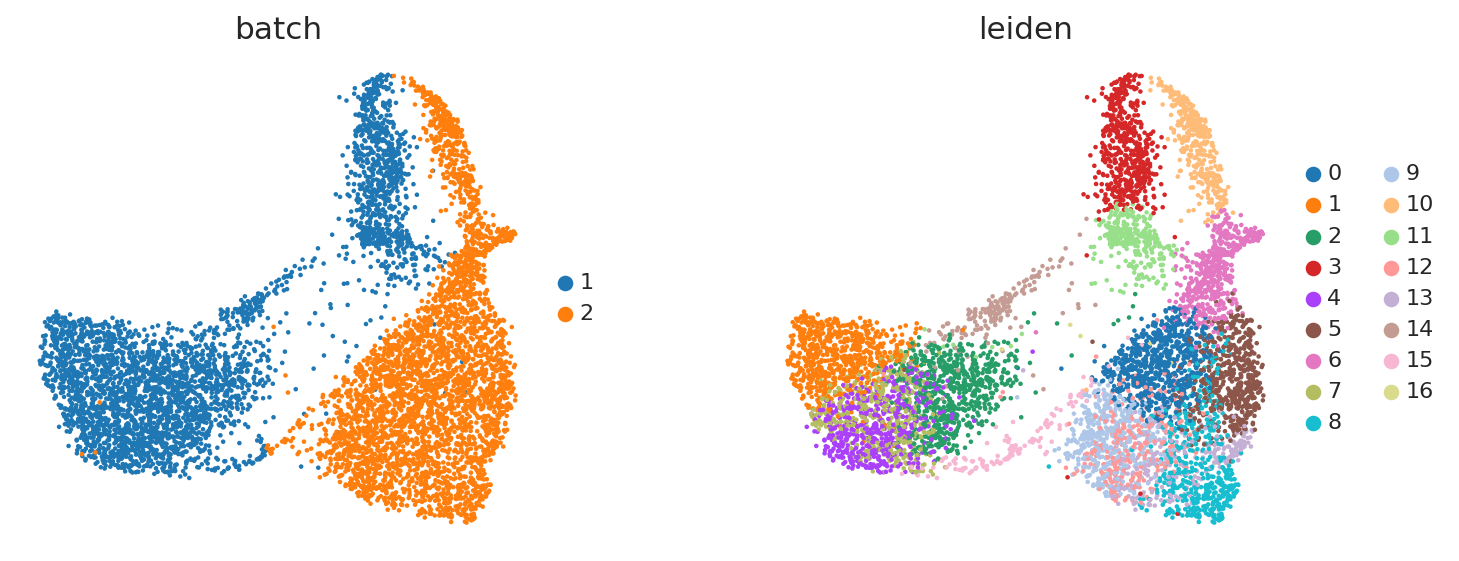

In [55]:
sc.pl.umap(adata,color=['batch','leiden'],legend_fontoutline=True,legend_fontsize=10,cmap='viridis',ncols=3,save='batch.png',wspace=0.3,frameon=False)

# 3. Harmony batch correction (no down sampling)

In [56]:
import harmonypy as hm

In [57]:
meta_data = pd.DataFrame(adata.obs['batch'])
meta_data

batch
Cells                      
AATGTTTGAAACAGGG-1        1
AAGCTATGAAGTGATGC-1       1
ATCTAGCAGAATGTTTG-1       1
AGAGGTGGATGGATTA-1        1
GATTGGCGTTACAGCGGA-1      1
...                     ...
AGTTACCGCAGCGTAGG-2       2
GAGTCCAAAGGGAAACAG-2      2
TGAAACACACGGAGCCCAT-2     2
TGACACAAGGCGCACCTCT-2     2
TGACCATTACTCCAACCGT-2     2

[7128 rows x 1 columns]

In [58]:
vars_use = ['batch']
data_mat = adata.obsm['X_pca'][:,:5]
data_mat.shape

(7128, 5)

In [59]:
ho = hm.run_harmony(data_mat, meta_data, vars_use,max_iter_harmony=50)

2022-11-11 14:56:02,522 - harmonypy - INFO - Iteration 1 of 50
2022-11-11 14:56:03,670 - harmonypy - INFO - Iteration 2 of 50
2022-11-11 14:56:04,748 - harmonypy - INFO - Converged after 2 iterations


In [60]:
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

In [61]:
adata.obsm['X_pca_harmony'] = res.T.values

In [62]:
sc.pp.neighbors(adata,n_neighbors=neighborhood_k,use_rep='X_pca_harmony',random_state=0)
sc.tl.umap(adata,min_dist=0.25,random_state=0)
sc.tl.leiden(adata,resolution=1,random_state=0)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


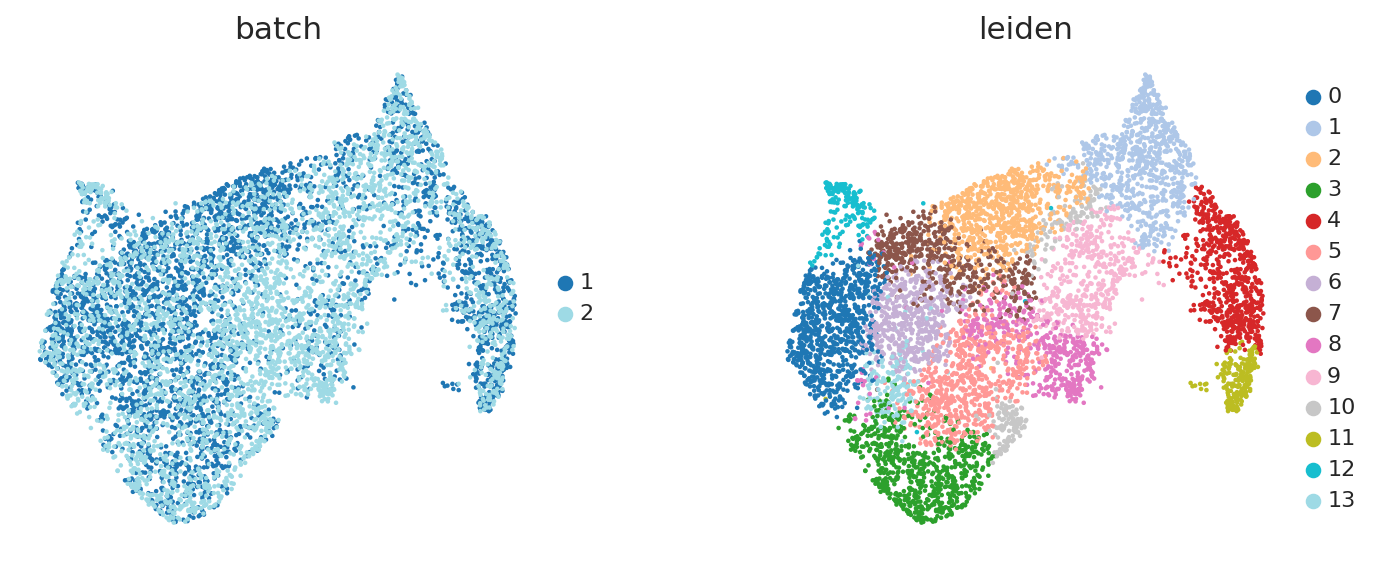

In [63]:
sc.pl.umap(adata,color=['batch','leiden'],legend_fontoutline=True,legend_fontsize=10,palette='tab20',ncols=3,save='batch.png',wspace=0.3,frameon=False)

# 4. Seurat MNN batch correction (no down sampling)

# 5. Down sample with chuck's code

# 6. Harmony batch correction (with down sampling)

# 7. Seurat MNN batch correction (with down sampling)